## Import 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import skew

# Funzioni di utilità dal file locale
from loan_utils import loan_feature_descriptor, check_skew_and_log_effect, suggest_log_transform


## Caricamento del dataset completo

In [3]:
# Carichiamo il dataset completo con tutte le 122 colonne originali
df = pd.read_csv("Dataset/application_train_all_col.csv")

# Mostriamo le dimensioni del dataset
print("Shape del dataset:", df.shape)

# Importiamo le funzioni di analisi esplorativa
#from loan_utils import loan_feature_descriptor, check_skew_and_log_effect

Shape del dataset: (307511, 122)


In [4]:
df = df.drop_duplicates()
print(f" Record dopo la rimozione dei duplicati: {df.shape[0]}")

 Record dopo la rimozione dei duplicati: 307511


##  Analisi iniziale del dataset con funzioni di supporto

In [5]:
# Analisi delle variabili numeriche: statistica descrittiva, missing e skewness
loan_feature_descriptor(df)

==== STATISTICHE DESCRITTIVE ====
                               count           mean            std       min  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348  100002.0   
CNT_CHILDREN                307511.0       0.417052       0.722121       0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996   45000.0   
AMT_ANNUITY                 307499.0   27108.573909   14493.737315    1615.5   
...                              ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685       0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295       0.0   

     

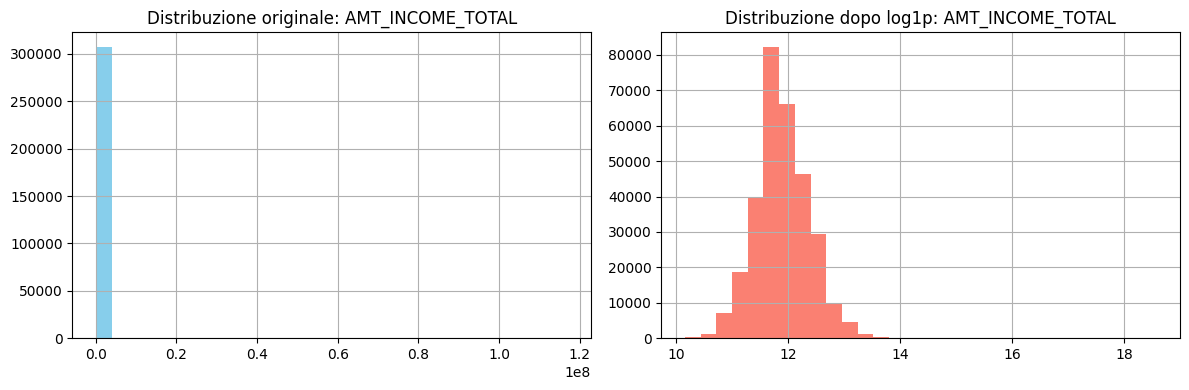

In [6]:
# Analisi visiva della skewness: esempio su 'AMT_INCOME_TOTAL'
check_skew_and_log_effect(df, 'AMT_INCOME_TOTAL')

#il risultato è che risulta fortemente asimmetrica e la trsformazione logaritmica migliora la distribuzioneù
#quindi la applichiamo
df['AMT_INCOME_TOTAL_LOG'] = np.log1p(df['AMT_INCOME_TOTAL'])

##  Feature Engineering esteso - creazione variabili derivate

In [7]:
# Età in anni (positivo) calcolata dai giorni dalla nascita (valori negativi nel dataset)
df['AGE'] = -df['DAYS_BIRTH'] / 365

# Anni di lavoro calcolati da DAYS_EMPLOYED (anch'esso negativo)
df['WORK_YEARS'] = -df['DAYS_EMPLOYED'] / 365

# Rapporto tra credito richiesto e reddito dichiarato
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)

# Rapporto tra rata annua e reddito dichiarato
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)

## Selezione delle feature per la classificazione

In [8]:
# Elenco delle feature numeriche e categoriche selezionate per l'analisi
features_to_use = [
    'AGE', 'WORK_YEARS', 'AMT_INCOME_TOTAL', #'AMT_INCOME_TOTAL_LOG', 
    'AMT_CREDIT', 'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'REGION_RATING_CLIENT'
]

# Filtriamo solo le colonne selezionate più il target
df_filtered = df[features_to_use + ['TARGET']]

In [9]:
# controllo percentuale di valori mancanti per colonna, per capire se ci sono colonne con troppi missing
missing = df_filtered.isnull().mean().sort_values(ascending=False)
print("Valori mancanti (% per colonna):")
print((missing * 100).round(2)[missing > 0])


Valori mancanti (% per colonna):
EXT_SOURCE_1            56.38
OCCUPATION_TYPE         31.35
EXT_SOURCE_3            19.83
EXT_SOURCE_2             0.21
ANNUITY_INCOME_RATIO     0.00
dtype: float64


In [10]:
#calcolo le colonne con skewness e suggerisco trasformazioni logaritmiche
cols_to_log = suggest_log_transform(df_filtered, threshold=1.0, verbose=True)
print("Colonne consigliate per log-transform:", cols_to_log)

 AMT_INCOME_TOTAL: skew originale = 391.56, dopo log1p = 0.17 → ✔ consigliata log-transform
 AMT_CREDIT: skew originale = 1.23, dopo log1p = -0.34 → ✔ consigliata log-transform
 CREDIT_INCOME_RATIO: skew originale = 1.84, dopo log1p = 0.20 → ✔ consigliata log-transform
 ANNUITY_INCOME_RATIO: skew originale = 1.51, dopo log1p = 1.07 → ✔ consigliata log-transform
 TARGET: skew originale = 3.08, dopo log1p = 3.08 → ✔ consigliata log-transform
Colonne consigliate per log-transform: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'TARGET']


In [11]:
import numpy as np

# 1. Applicazione log1p alle feature selezionate
df['LOG_AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])
df['LOG_AMT_CREDIT'] = np.log1p(df['AMT_CREDIT'])
df['LOG_CREDIT_INCOME_RATIO'] = np.log1p(df['CREDIT_INCOME_RATIO'])
df['LOG_ANNUITY_INCOME_RATIO'] = np.log1p(df['ANNUITY_INCOME_RATIO'])

# 2. Nuova lista di feature da usare (log trasformate incluse, originali escluse dove trasformate)
features_to_use = [
    'AGE', 'WORK_YEARS', 
    'LOG_AMT_INCOME_TOTAL',    # al posto di 'AMT_INCOME_TOTAL'
    'LOG_AMT_CREDIT',          # al posto di 'AMT_CREDIT'
    'LOG_CREDIT_INCOME_RATIO', # al posto di 'CREDIT_INCOME_RATIO'
    'LOG_ANNUITY_INCOME_RATIO',# al posto di 'ANNUITY_INCOME_RATIO'
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'REGION_RATING_CLIENT'
]

# 3. Creazione del nuovo dataframe filtrato
df_filtered = df[features_to_use + ['TARGET']]


## Trattamento dei valori mancanti e codifica delle variabili categoriche

In [12]:
# Elenco di colonne numeriche coerente con le trasformazioni effettuate
numerical_features = [
    'AGE', 'WORK_YEARS',
    'LOG_AMT_INCOME_TOTAL',       # al posto di 'AMT_INCOME_TOTAL'
    'LOG_AMT_CREDIT',             # al posto di 'AMT_CREDIT'
    'LOG_CREDIT_INCOME_RATIO',    # al posto di 'CREDIT_INCOME_RATIO'
    'LOG_ANNUITY_INCOME_RATIO',   # al posto di 'ANNUITY_INCOME_RATIO'
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'REGION_RATING_CLIENT'
]

#  Le colonne categoriche restano invariate
categorical_features = ['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE']


In [14]:
from sklearn.impute import SimpleImputer

# Imputazione valori mancanti:
# - Mediana: preferibile in presenza di distribuzioni asimmetriche (skewed) o dati con outliers,
#   perché meno influenzata dai valori estremi.
# - Media: utile se la distribuzione è simmetrica e senza valori estremi significativi, 
#   altrimenti potrebbe distorcere la distribuzione originale.

# Imputazione mediana per le colonne numeriche
num_imputer = SimpleImputer(strategy='median')
df_filtered.loc[:, numerical_features] = num_imputer.fit_transform(df_filtered[numerical_features])

# Imputazione valore costante per le colonne categoriche
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df_filtered.loc[:, categorical_features] = cat_imputer.fit_transform(df_filtered[categorical_features])

n_nan = df_filtered.isnull().sum().sum()
n_inf = np.isinf(df_filtered[numerical_features]).sum().sum()

print(" Verifica completata:")
print(f" Valori NaN residui: {n_nan}")
print(f" Valori infiniti residui (inf / -inf): {n_inf}")

if n_nan == 0 and n_inf == 0:
    print(" Dataset pronto: nessun valore mancante o infinito.")
else:
    print(" Attenzione: ci sono ancora valori problematici.")

 Verifica completata:
 Valori NaN residui: 0
 Valori infiniti residui (inf / -inf): 0
 Dataset pronto: nessun valore mancante o infinito.


In [15]:
# One-Hot Encoding delle variabili categoriche
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Codifica e ricostruzione del DataFrame
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cat = encoder.fit_transform(df_filtered[categorical_features])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_features))

# Unione con le colonne numeriche e il target
df_final = pd.concat([
    df_filtered[numerical_features].reset_index(drop=True),
    encoded_cat_df.reset_index(drop=True),
    df_filtered['TARGET'].reset_index(drop=True)
], axis=1)

##  Salvataggio del dataset finale preprocessato

In [16]:
# Salva su CSV per l'addestramento dei modelli
df_final.to_csv("Dataset/application_train_cleaned.csv", index=False)
print("Dataset preprocessato salvato con successo!")

Dataset preprocessato salvato con successo!
